<a href="https://colab.research.google.com/github/amarmohammed398/COM64101_Assignment_part1_b22063am/blob/main/COM64101_Assignment_part1_b22063am.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Brief: Statistical Inference and Gaussian processes

## Deadline: November 18, 2025, 14:00 GMT

## Number of marks available: 35

This coursework is made of two parts. In the first part, you will explore different techniques for approximate inference. In the second part, you will use Bayesian optimisation for hyperparameter learning.

### Please READ the whole assignment first, before starting to work on it.

### How and what to submit

A. A **Jupyter Notebook** with the code in all the cells executed and outputs displayed.

B. Name your Notebook **COM64101_Assignment_part1_XXXXXX.ipynb** where XXXXXX is your username such as such as abc18de. Example: `COM64101_Assignment_abc18de.ipynb`

C. Upload the Jupyter Notebook in B to Canvas under the submission area before the deadline.

D. **NO DATA UPLOAD**: Please do not upload the data files used in this Notebook. We have a copy already.


### Assessment Criteria

* Being able to correctly apply frequentist, Bayesian, Monte Carlo, importance sampling, and variational inference methods as specified in each task.

* Being able to provide clear comparisons between methods (e.g., MLE vs. Bayesian, plain MC vs. IS, VI vs. HMC) using appropriate metrics, plots, and variance/uncertainty evaluations.

* Being able to use Gaussian processes as a surrogate model for Bayesian optimisation of the hyperparameters of a machine learning model.

* Being able to concisely explain results, justify methodological choices, and discuss observed differences within the given word limits.

### Code quality and use of Python libraries
When writing your code, you will find out that there are operations that are repeated at least twice. If your code is unreadable, we may not award marks for that section. Make sure to check the following:

* Did you include Python functions to solve the question and avoid repeating code?
* Did you comment your code to make it readable to others?

### Late submissions

We follow Department's guidelines about late submissions, i.e., a deduction of 10% of the mark each 24 hours the work is late after the deadline. NO late submission will be marked one week after the deadline. Please read [this link](https://documents.manchester.ac.uk/display.aspx?DocID=29825).

### Academic malpractice

**Any form of unfair means is treated as a serious academic offence and action may be taken under the Discipline Regulations.** Please carefully read [what constitutes Academic Malpractice](https://documents.manchester.ac.uk/display.aspx?DocID=2870) if not sure. If you still have questions, please ask your Personal tutor or the Lecturers.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Statistical Inference (20 marks)

Section 1 of this coursework is made of three parts (Part 1.1, Part 1.2, and Part 1.3). Complete the tasks below. Do **not** modify the provided datasets.

For Part 1.1, you need to analyze coin-flip data using both frequentist (MLE + Wald CI) and Bayesian (Beta prior + posterior sampling) methods, compare their predictions for future flips, and understand the differences. For Part 1.2, you need to estimate a 2D integral using plain Monte Carlo and importance sampling. For Part 1.3, you need to fit Bayesian logistic regression using both mean-field variational inference and HMC, compare their posterior approximations (via KL divergence and test log-loss).

## 1.1 Bayesian vs. Frequentist Modelling (5 marks)

In this exercise, you will explore two different statistical paradigms—**frequentist inference** and **Bayesian inference**—applied to the problem of estimating a coin’s probability of landing heads. The dataset `coin_experiments.csv` contains 1,000 independent coin-flip experiments, each recording the number of **successes** (heads) and the total **trials**.  

**Question**

**1.1.A.** The frequentist approach treats the probability of success, $p$, as a fixed but unknown quantity. You will:  
- Import the data, print its shape, and check basic sanity (e.g., no missing values, successes ≤ trials). **(0.5 pt)**  
- Compute the **Maximum Likelihood Estimate (MLE)**, $\hat{p} = S/N$, where $S$ is the total number of successes and $N$ is the total number of trials. **(1 pt)**
-  Estimate the standard error,  
  $$\text{SE} = \sqrt{\hat{p}(1-\hat{p})/N},$$  
  and form a **95% Wald confidence interval** using $z = 1.96$. **(0.5 pt)**

**Answer**

In [3]:

# Imports
import numpy as np
import pandas as pd

# upload coin_experiments.csv
try:
    from google.colab import files
    _ = files.upload()
    csv_path = "coin_experiments.csv"
except Exception:
    csv_path = "coin_experiments.csv"

# Load the dataset
df = pd.read_csv(csv_path)

# print shape and run basic sanity checks
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(3), "\n")

missing_total = df.isna().sum().sum()
assert missing_total == 0, f"Dataset has {missing_total} missing values."

# Ensure required columns exist
assert {"successes", "trials"}.issubset(df.columns), "Expected 'successes' and 'trials' columns."

# Ensure counts are nonnegative integers and successes ≤ trials
assert (df["successes"] >= 0).all(), "Negative successes found."
assert (df["trials"] >= 0).all(), "Negative trials found."
assert np.allclose(df["successes"], df["successes"].round()), "Non-integer successes found."
assert np.allclose(df["trials"], df["trials"].round()), "Non-integer trials found."
assert (df["successes"] <= df["trials"]).all(), "Found rows with successes > trials."

print("Sanity checks passed\n")

# Compute S, N, p-hat (MLE), SE, and 95% Wald CI
S = int(df["successes"].sum())
N = int(df["trials"].sum())
p_hat = S / N

SE = np.sqrt(p_hat * (1 - p_hat) / N)
z = 1.96  # 95% CI
ci_low = p_hat - z * SE
ci_high = p_hat + z * SE

# print results
print("=== Frequentist Estimate for Coin's Head Probability ===")
print(f"Total successes (S): {S}")
print(f"Total trials    (N): {N}")
print(f"MLE p-hat (S/N)     : {p_hat:.6f}")
print(f"Standard Error      : {SE:.6f}")
print(f"95% Wald CI         : [{ci_low:.6f}, {ci_high:.6f}]")


Saving coin_experiments.csv to coin_experiments (2).csv
Shape: (1000, 2)
Columns: ['successes', 'trials']
   successes  trials
0         29      48
1         18      38
2         17      24 

Sanity checks passed

=== Frequentist Estimate for Coin's Head Probability ===
Total successes (S): 18212
Total trials    (N): 30338
MLE p-hat (S/N)     : 0.600303
Standard Error      : 0.002812
95% Wald CI         : [0.594791, 0.605815]


**Question**

**1.1.B.** The Bayesian approach treats $p$ as a **random variable** with prior distribution. Using a **Beta(1, 1)** prior (uniform), you will:  
- Compute the posterior parameters,  
  $$\alpha_{\text{post}} = \alpha_0 + S, \quad \beta_{\text{post}} = \beta_0 + (N-S),$$  
  and the **MAP estimate**,  
  $$p_{\text{MAP}} = \frac{\alpha_{\text{post}} - 1}{\alpha_{\text{post}} + \beta_{\text{post}} - 2}.$$
  **(1 pt)**
- Draw at least 5,000 samples from the Beta posterior (e.g., `scipy.stats.beta.rvs`). **(0.5 pt)**

**Answer**

In [6]:
# --- Bayesian Beta-Binomial with Beta(1,1) prior (no repeated imports) ---

# Posterior parameters (conjugate update)
alpha0, beta0 = 1, 1
alpha_post = alpha0 + S
beta_post  = beta0 + (N - S)

# MAP estimate (valid since alpha_post > 1 and beta_post > 1 here)
p_map = (alpha_post - 1) / (alpha_post + beta_post - 2)

# Draw >= 5,000 samples from Beta(alpha_post, beta_post)
rng = np.random.default_rng(42)     # reproducible
num_samples = 10_000                # ≥ 5,000 as requested
samples = rng.beta(alpha_post, beta_post, size=num_samples)

# Posterior summaries (from both conjugacy and samples)
post_mean_closed = alpha_post / (alpha_post + beta_post)  # exact mean of Beta
post_mean_samp   = samples.mean()
post_sd_samp     = samples.std(ddof=1)
ci2p5, ci97p5    = np.quantile(samples, [0.025, 0.975])

# Print results
print("=== Bayesian Beta-Binomial Update (Beta(1,1) prior) ===")
print(f"S (total successes): {S}")
print(f"N (total trials)   : {N}")
print(f"alpha_post         : {alpha_post}")
print(f"beta_post          : {beta_post}")
print(f"MAP estimate       : {p_map:.8f}")
print(f"Posterior mean (closed-form): {post_mean_closed:.8f}")
print(f"Posterior mean (samples)    : {post_mean_samp:.8f}")
print(f"Posterior SD (samples)      : {post_sd_samp:.8f}")
print(f"95% credible int (samples)  : [{ci2p5:.8f}, {ci97p5:.8f}]")


=== Bayesian Beta-Binomial Update (Beta(1,1) prior) ===
S (total successes): 18212
N (total trials)   : 30338
alpha_post         : 18213
beta_post          : 12127
MAP estimate       : 0.60030325
Posterior mean (closed-form): 0.60029664
Posterior mean (samples)    : 0.60032458
Posterior SD (samples)      : 0.00283830
95% credible int (samples)  : [0.59474946, 0.60580302]


**Question**

**1.1.C.** Finally, compare predictions for the next **20 flips**:  
- From the Bayesian model, simulate posterior predictive outcomes by sampling from a **Binomial(20, p)** where $p$ comes from the posterior samples, and show a histogram/density. **(0.5 pt)**
- From the frequentist model, plot the **plug-in Binomial pmf** with $p = \hat{p}_{\text{MLE}}$ over the same figure.**(0.5 pt)**

**Answer**

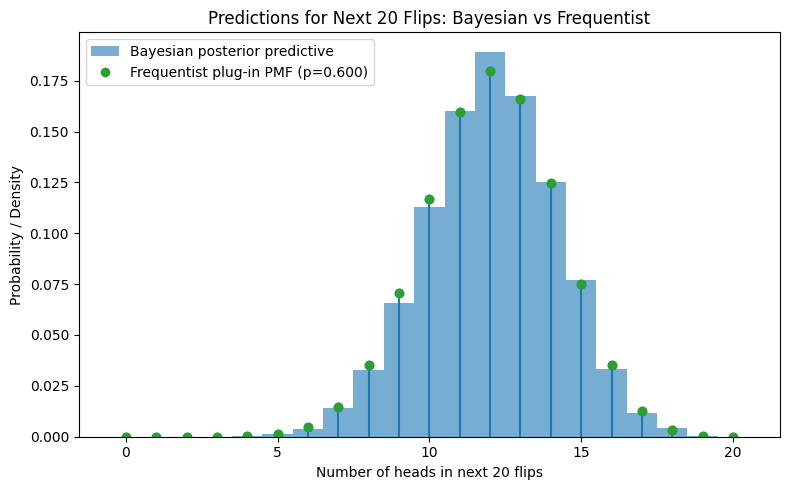

In [8]:
# Ensure posterior samples exist
try:
    samples
except NameError:
    rng = np.random.default_rng(123)
    samples = rng.beta(alpha_post, beta_post, size=10_000)
else:
    rng = np.random.default_rng(123)

# Posterior predictive for next 20 flips
n_future = 20
y_pred = rng.binomial(n_future, samples)

# Frequentist plug-in pmf with p = p_hat
k = np.arange(0, n_future + 1)
pmf_freq = np.array([comb(n_future, ki) * (p_hat ** ki) * ((1 - p_hat) ** (n_future - ki)) for ki in k])

# Plot
plt.figure(figsize=(8,5))

# Bayesian posterior predictive histogram (normalized)
plt.hist(
    y_pred,
    bins=np.arange(-0.5, n_future + 1.5, 1),
    density=True,
    alpha=0.6,
    label="Bayesian posterior predictive"
)

# Frequentist plug-in PMF (no use_line_collection)
stems = plt.stem(k, pmf_freq, basefmt=" ")
stems.baseline.set_visible(False)             # hide baseline to reduce clutter
plt.plot(k, pmf_freq, marker="o", linestyle="none",
         label=f"Frequentist plug-in PMF (p={p_hat:.3f})")

plt.xlabel("Number of heads in next 20 flips")
plt.ylabel("Probability / Density")
plt.title("Predictions for Next 20 Flips: Bayesian vs Frequentist")
plt.legend()
plt.tight_layout()
plt.show()


**Question**

**1.1.D.** Write a short explanation comparing the two predictive distributions. Comment on how the Bayesian posterior predictive accounts for uncertainty in $p$, while the frequentist plug-in relies on a single point estimate. **(0.5 pt)**  

**Answer**


**Frequentist plug-in prediction**
- Treats the coin’s head probability \(p\) as **known** and equal to the single estimate \(\hat p\).
- Predicts heads in the next \(n=20\) flips with a **Binomial**\((20, \hat p)\).
- Captures only the **flip-to-flip randomness** given a fixed \(p\).

**Bayesian posterior predictive**
- Treats \(p\) as **unknown** but updated by the data via the posterior \(\mathrm{Beta}(\alpha_{\text{post}}, \beta_{\text{post}})\).
- Predicts by averaging \(\mathrm{Binomial}(20, p)\) over the posterior for \(p\), yielding a **Beta–Binomial** distribution.
- Captures **two** uncertainties:
  1) randomness of the 20 flips, and  
  2) remaining uncertainty about \(p\).

**Comparison (what you’ll see)**
- Both are centered near \(20 \hat p\) (means are nearly the same).
- The **Bayesian** curve is typically **slightly wider** (more variance) because it integrates over uncertainty in \(p\).
- With a large dataset (as here), the posterior for \(p\) is very concentrated, so the two predictions look **almost identical**, with the Bayesian one just a touch wider.






## 1.2 Variance Reduction with Importance Sampling (5 marks)

Many integrals that arise in statistics and machine learning cannot be evaluated analytically, especially in higher dimensions. **Monte Carlo (MC) integration** is a general technique to approximate such integrals by drawing random samples from a distribution and averaging function evaluations. Although MC estimators are unbiased, their variance can be large, meaning we may need many samples to reach a desired accuracy.  

A way to improve efficiency is through **importance sampling (IS)**. Instead of sampling from a fixed distribution (e.g., Gaussian), we choose a proposal distribution $q(x)$ that better matches the regions where the integrand contributes most. By reweighting samples, we can reduce variance while keeping the estimator unbiased. The effectiveness of IS depends critically on choosing $q(x)$ with heavier tails or shapes aligned with the integrand.  

In this exercise, you will evaluate a 2D integral and demonstrate how importance sampling can achieve significant variance reduction compared to plain Monte Carlo:  

$$
I = \int_{\mathbb{R}^2} \exp(-\|x\|_1)\,\sin(\|x\|_2)\,dx,
$$  

with the goal of achieving an **absolute error < 0.01**.  

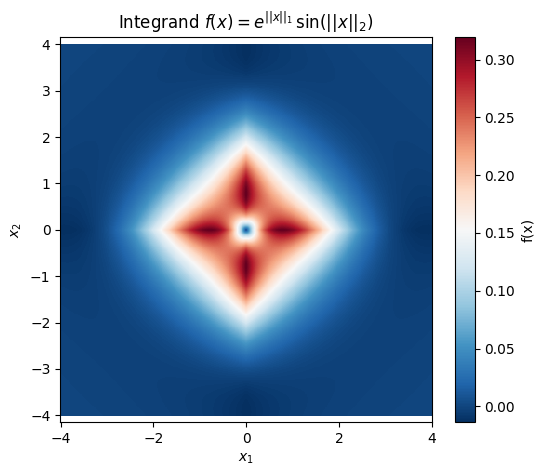

In [9]:
# Visualize the integrand
import numpy as np
import matplotlib.pyplot as plt

def integrand(x):
    l1 = np.sum(np.abs(x), axis=-1)   # L1 norm
    l2 = np.linalg.norm(x, axis=-1)   # L2 norm
    return np.exp(-l1) * np.sin(l2)

# grid
xx, yy = np.meshgrid(np.linspace(-4,4,400), np.linspace(-4,4,400))
pts = np.stack([xx,yy], axis=-1)
zz = integrand(pts)

# plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xx, yy, zz, cmap="RdBu_r", shading="auto")
plt.colorbar(label="f(x)")
plt.title("Integrand $f(x) = e^{||x||_1} \\, \\sin(||x||_2)$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.show()


**Question**

**1.2.A. Plain Monte Carlo (2 pts)**  
   - Estimate $I$ by sampling $x \sim \mathcal{N}(0, I_2)$ using the plain Monte Carlo estimator **(1 pt)**:  
     $$
     \hat{I} = \frac{1}{N} \sum_{i=1}^N f(x_i), \quad x_i \sim \mathcal{N}(0, I_2).
     $$  
   - Report your estimate $\hat{I}$ and the **empirical standard error**. Verify that the error decreases as $N$ increases. **(1 pt)**

**Answer**

In [ ]:
# Write your code here

**Question**

**1.2.B Importance Sampling (1.5 pts)**  
   - Design your own proposal distribution $q(x)$ and implement an importance sampling estimator.**(1 pt)**
   - Demonstrate a **variance reduction** for an equal number of samples **(0.5 pt)**
   - *Hint:* Consider proposals (e.g., Laplace, Student-t or other) to better capture the integrand’s structure.  

**Answer**

In [ ]:
# Write your code here

**Question**

**1.2.C RMSE Comparison (1 pt)**  
   - Produce a **log–log plot** of RMSE vs. sample size $N$, comparing plain Monte Carlo and importance sampling. **(1 pt)**  
   - Use $N \in [10^3, 10^5]$ (e.g., 5–10 log-spaced points). Ensure both curves are clearly labeled.

**Answer**

In [ ]:
# Write your code here

**Question**

**1.2.D. Justification (0.5 pt)**  
   - Explain your choice of proposal $q(x)$. Discuss how it aligns with the shape of the integrand and why it reduces variance relative to Gaussian sampling. **(0.5 pt)**

**Answer**

## 1.3 Mean-Field Variational Inference for Bayesian Logistic Regression (10 marks, ★ difficult)

In this exercise, you will implement **Bayesian logistic regression** and approximate its posterior distribution using **mean-field variational inference (VI)**. You will then compare VI with a **Hamiltonian Monte Carlo (HMC)** benchmark to highlight the trade-offs between computational efficiency and posterior accuracy. The dataset `log_reg_data.csv` contains predictors `x1, x2, …` and a binary label `y`.

### Background & Motivation

- **Bayesian logistic regression** models uncertainty in the regression weights $w$, allowing you to quantify predictive uncertainty rather than relying only on a point estimate (as in standard logistic regression). The prior is chosen as a Gaussian:  
  $$
  w \sim \mathcal{N}(0, 10I).
  $$  

- **Variational Inference (VI)** approximates the true posterior $p(w \mid D)$ by a simpler distribution. Here, we use a **mean-field Gaussian**:  
  $$
  q_\phi(w) = \mathcal{N}(w \mid \mu, \mathrm{diag}(\sigma^2)),
  $$  
  where the parameters $\phi = (\mu, \sigma)$ are optimised to make $q_\phi$ close to the true posterior.  

- Optimisation is done via the **Evidence Lower Bound (ELBO)**:  
  $$
  \mathcal{L}(\phi) = \mathbb{E}_{q_\phi}[ \log p(D \mid w) ] - \mathrm{KL}(q_\phi \,\|\, p(w)),
  $$  
  which we estimate stochastically using the **reparameterisation trick**:  
  $$
  w = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I).
  $$  

- **Hamiltonian Monte Carlo (HMC)** provides a high-fidelity posterior approximation by simulating from the exact Bayesian posterior using gradient information. It is computationally more expensive but is often treated as the “gold standard” for comparison.  

By completing this task, you will see how VI provides a fast but approximate solution, while HMC is slower but more accurate. The comparison highlights the **bias–variance trade-off** in approximate inference.
**Hint:**  
- Use `autograd` for gradients in VI.  
- Clip `log_sigma` to avoid extreme variances.  
- Use `scipy.special.expit` for the logistic function.  
- For HMC, you can rely on **NumPyro** (already available) to avoid implementing HMC from scratch.

**Question**

**1.3.A Variational Inference (3 pts)**  
   - Construct the VI family and implement the **reparameterised ELBO**. Optimise with SGD/ADAM. **(2 pt)**
   - Show a training curve of the ELBO to confirm convergence. **(1 pt)**

In [ ]:
!pip install autograd

In [ ]:
import numpy as np
import pandas as pd
from autograd import grad
import autograd.numpy as anp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**Answer**

In [ ]:
# Write your code here

JAX is a Python library that works like NumPy but adds extra features such as automatic differentiation and faster computations. NumPyro is a library built on JAX that makes it easier to do Bayesian statistics and probabilistic modeling. You should use JAX together with NumPyro, complete the following task:

**Question**

**1.3.B HMC Benchmark (2 pt)**  
   - Run **4 parallel HMC chains** (NumPyro/Stan acceptable) to obtain ≥1,000 effective samples.  
   - Report convergence diagnostics ($\hat{R} \leq 1.05$).  

In [ ]:
!pip install jax
!pip install jaxlib
!pip install numpyro

In [ ]:
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import summary

**Answer**

In [ ]:
# Write your code here

**Question**

**1.3.C Posterior Comparison (3 pts)**  
   - Compute $\mathrm{KL}(q_\phi \parallel p(w \mid D))$ using HMC samples as the reference posterior. **(2 pt)**  
   - Compute test-set log-loss under both VI and HMC. Present results in a table or plot. **(1 pt)**

In [ ]:
import numpy as np
from sklearn.metrics import log_loss
from scipy.special import expit

**Answer**

In [ ]:
# Write your code here

**Question**

**1.3.D Discussion (2 pt)**  
   - Discuss where VI diverges from HMC. Comment on underestimation of uncertainty, mode-seeking bias, and the speed vs. accuracy trade-off.  


**Answer**

# 2. Gaussian processes and Bayesian Optimisation (15 marks)

This part of the coursework uses Gaussian processes for Bayesian optimisation of the hyperparameters of a Machine Learning model. The dataset you will use in this assignment comes from a popular machine learning repository that hosts open source datasets for educational and research purposes, the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). The task is  to predict electrical energy output from a [combined cycle Power Plant](https://en.wikipedia.org/wiki/Combined_cycle_power_plant). The description of the dataset can be found [here](https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant).

## Bayesian optimisation of Elastic net hyperparameters

You will use Thompson Sampling (TS) for hyperparemeter learning of an [elastic net model for regression](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net) over the electrical energy output dataset. Before moving on, please read the mathematical description of the Elastic net model [here](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net). The two hyperparameters to optimise will be the $\alpha>0$ parameter and the $0\le\rho\le1$ parameter. The $\alpha$ and $\rho$ hyperparameters are related to the level of $\ell_1$ and $\ell_2$ regularisaion done for the linear regression model. The exact relationship between these parameters is explained [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet).

The function we want to minimise will be the Root Mean-Squared Error (RMSE) on a validation dataset,

\begin{align}
    \text{RMSE}(\alpha, \rho) = \sqrt{\text{MSE}(\mathbf{y}_\text{val}, f(\mathbf{x}_{\text{val}}, \mathcal{D}_\text{train}, \alpha, \rho))},
\end{align}

where $\text{MSE}(\mathbf{y}_\text{val}, f(\mathbf{x}_{\text{val}}, \mathcal{D}_\text{train}, \alpha, \rho))$ is the Mean-Squared error between the validation data and the prediction of the elastic net model, which in turn is a function of the training data, $\mathcal{D}_\text{train}$, and the hyperparameters $\alpha$ and $\rho$.

**IMPORTANT. You can use scikit-learn for implementing the Elastic Net regressor. You can also use any library for the Gaussian process surrogate model. However, you CAN NOT use any package for the Bayesian optimisation loop. Failure to follow these instructions, will lead to a mark of zero for this section of the assignment.**

We will first load the dataset and split it into training, validation and test sets.

In [ ]:
import urllib.request
doq = "https://archive.ics.uci.edu/static/public/294/combined+cycle+power+plant.zip"
pat_sav = "./combined+cycle+power+plant.zip"
urllib.request.urlretrieve(doq, pat_sav)

In [ ]:
import zipfile
zip = zipfile.ZipFile('./combined+cycle+power+plant.zip', 'r')
for name in zip.namelist():
    zip.extract(name, '.')

In [ ]:
import pandas as pd
import numpy as np
energy_output = pd.read_excel('./CCPP/Folds5x2_pp.xlsx','Sheet1')

The dataset has 9568 observations. We will use a subset of $N_m$ for this exercise. From those, we will select $80\%$ as the training data, $10\%$ as the validation data, and $10\%$ as the test data.

In [ ]:
N_m = 9000
ndata, ncols = np.shape(energy_output)
np.random.seed(22222)                 # Make sure you use the last five digits of your student UCard as your seed
index = np.random.permutation(ndata)  # We permute the indexes
data_tot_red = energy_output.iloc[index[0:N_m], :].copy() # Select N_m points
Ne = np.int64(np.round(0.8*N_m))    # We compute N, the number of training instances
Neval = np.int64(np.round(0.1*N_m)) # We compute Nval, the number of validation instances
Netest = N_m - Ne - Neval              # We compute Ntest, the number of test instances
index = np.random.permutation(N_m)  # We permute the indexes
data_training = data_tot_red.iloc[index[0:Ne], :].copy() # Select the training data
data_val = data_tot_red.iloc[index[Ne:Ne+Neval], :].copy() # Select the validation data
data_test = data_tot_red.iloc[index[Ne+Neval:N_m], :].copy() # Select the test data

In [ ]:
Xe_train = np.concatenate((np.ones((Ne,1)), (data_training.iloc[:, 0:4]).values), axis=1)
ye_train = np.reshape((data_training.iloc[:, 4]).values, (Ne,1))
Xe_val = np.concatenate((np.ones((Neval,1)), (data_val.iloc[:, 0:4]).values), axis=1)
ye_val = np.reshape((data_val.iloc[:, 4]).values, (Neval,1))
Xe_test = np.concatenate((np.ones((Netest,1)), (data_test.iloc[:, 0:4]).values), axis=1)
ye_test = np.reshape((data_test.iloc[:, 4]).values, (Netest,1))

### 2.1 Initial space filling-design (5 marks)

We start by collecting a few initial points from the function we want to optimise. Here, you will assume the first initial design has $n_0 = 5$ points. The ouput of this part of your code should be the data observations ``X0train`` and ``y0train``

**Answer**

In [ ]:
# Write the code to get n_0=5 points for the initial design

### 2.2 Implement the sequentail-decision loop to find the optimal set of hyperparameters (5 marks)

Assume your optimisation budget is equal to $N = 20$ function evaluations and implement your Bayesian optimiser. For each iteration in the optimisation, you need to:

1. Compute the posterior distribution of your Gaussian process using all available training data.
2. Use Thompson sampling to find the optimal value to explore next.
3. Observe your new output at the suggested optimal point.

At the end of the optimisation loop, you should return a value of $\alpha_*$ and $\rho_*$.

**Answer**

In [ ]:
# Write your code here

### 2.3 Compute RMSE in the test set and compare the performance of the Bayes Opt approach against an alterntive method for hyperparameter selection (5 marks)

Compute the performance of the Elastic Net model over the test set.

**Answer**

In [ ]:
# Write your code here

Use an alternative approach for hyperparameter learning of $\alpha$ and $\rho$.

**Answer**

In [ ]:
# Write your code here

Write and discuss two interesting findings of this experiment.

- *Interesting finding 1*. Write a sentence here of no more than **30 words**.
- *Interesting finding 2*. Write a sentence here of no more than **30 words**.

**Answer**